In [35]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import shutil
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from google.colab import files
import seaborn as sns

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.Kaggle

In [4]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
100% 777M/778M [00:03<00:00, 305MB/s]
100% 778M/778M [00:03<00:00, 220MB/s]


In [5]:
!unzip '/content/covid19-radiography-database.zip'


Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

In [6]:
PATH_TO_METADATA = "/content/COVID-19_Radiography_Dataset/Normal.metadata.xlsx"
df = pd.read_excel(PATH_TO_METADATA)
df.head()

,FILE NAME,FORMAT,SIZE,URL
0,NORMAL-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,NORMAL-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,NORMAL-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,NORMAL-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,NORMAL-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [7]:
!ls /tmp

dap_multiplexer.048e7bec3727.root.log.INFO.20240709-060346.110
dap_multiplexer.INFO
debugger_ca2qbx5d0
initgoogle_syslog_dir.0
language_service.048e7bec3727.root.log.INFO.20240709-061248.2353
language_service.INFO
pyright-2359-H6yU0KWSBZiE
pyright-2359-Lq0Si7ndv8cC
python-languageserver-cancellation
tmpkui52i_f
tmpocch8zdq


In [8]:
!mkdir /tmp/Xray_train_data

In [9]:
!cp -R "/content/COVID-19_Radiography_Dataset/COVID/images" "/tmp/Xray_train_data/"

In [10]:
!mv "/tmp/Xray_train_data/images" "/tmp/Xray_train_data/COVID"

In [11]:
!ls -1 "/tmp/Xray_train_data/COVID"| wc -l

3616


In [12]:
!mkdir "/tmp/Xray_train_data/NORMAL"

In [13]:
cnt = 0
for (i, row) in df.iterrows():
    if (cnt < 3616):
        filename = row["FILE NAME"].lower().capitalize() + "." + row["FORMAT"].lower()
        image_path = os.path.join("/content/COVID-19_Radiography_Dataset/Normal/images", filename)
        image_copy_path = os.path.join("/tmp/Xray_train_data/NORMAL", filename)
        shutil.copy2(image_path, image_copy_path)
        cnt += 1

print(cnt)

3616


In [14]:
!ls "/tmp/Xray_train_data"

COVID  NORMAL


In [15]:
!ls -1 "/tmp/Xray_train_data/COVID"| wc -l

3616


In [16]:
!ls -1 "/tmp/Xray_train_data/NORMAL"| wc -l

3616


In [17]:
train_data_dir= "/tmp/Xray_train_data"

In [18]:
IMAGE_SIZE = (299, 299)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

In [19]:
img_height, img_width=IMAGE_SIZE
batch_size=16
train_datagen = ImageDataGenerator(validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

Found 5064 images belonging to 2 classes.
Found 5064 images belonging to 2 classes.


In [20]:
xception_model = Sequential()
pre_model = tf.keras.applications.Xception(
    include_top=False,
    input_shape=(299, 299, 3),
    pooling='avg',
    weights='imagenet'
)
for layer in pre_model.layers:
    layer.trainable = False
xception_model.add(pre_model)
xception_model.add(Flatten())
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(1, activation='sigmoid'))

83683744/83683744 [==============================] - 0s 0us/step


In [21]:
xception_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [22]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 2, patience = 4)

trainer=xception_model.fit(train_generator,validation_data=validation_generator,epochs=30, callbacks = [es])

Epoch 1/30
317/317 [==============================] - 79s 222ms/step - loss: 0.8817 - accuracy: 0.7273 - val_loss: 0.4123 - val_accuracy: 0.8276
Epoch 2/30
317/317 [==============================] - 77s 242ms/step - loss: 0.4932 - accuracy: 0.8142 - val_loss: 0.3527 - val_accuracy: 0.8624
Epoch 3/30
317/317 [==============================] - 73s 229ms/step - loss: 0.5420 - accuracy: 0.8126 - val_loss: 0.2912 - val_accuracy: 0.8799
Epoch 4/30
317/317 [==============================] - 72s 228ms/step - loss: 0.4413 - accuracy: 0.8377 - val_loss: 0.6502 - val_accuracy: 0.7774
Epoch 5/30
317/317 [==============================] - 72s 228ms/step - loss: 0.3783 - accuracy: 0.8533 - val_loss: 0.2662 - val_accuracy: 0.8920
Epoch 6/30
317/317 [==============================] - 72s 228ms/step - loss: 0.4162 - accuracy: 0.8493 - val_loss: 0.2400 - val_accuracy: 0.9054
Epoch 7/30
317/317 [==============================] - 72s 228ms/step - loss: 0.3590 - accuracy: 0.8705 - val_loss: 0.3064 - val_ac

In [23]:
xception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 21911081 (83.58 MB)
Trainable params: 1049601 (4.00 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


Text(0.5, 1.0, 'Training-Validation Accuracy')

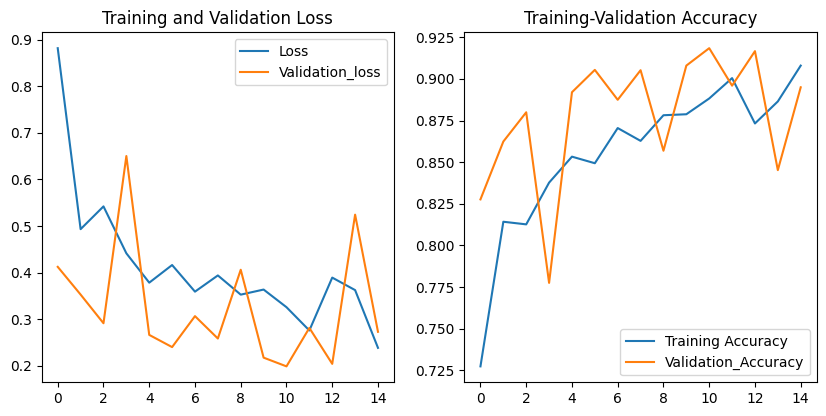

In [25]:
loss=pd.DataFrame(xception_model.history.history)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(loss["loss"],label="Loss")
plt.plot(loss["val_loss"],label="Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label="Training Accuracy")
plt.plot(loss['val_accuracy'],label="Validation_Accuracy")
plt.legend()
plt.title("Training-Validation Accuracy")

In [27]:
probabilities = xception_model.predict_generator(generator=validation_generator)
print("Probability Predictor: \n",probabilities)

<ipython-input-27-2d0c8835e9f0>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  probabilities = xception_model.predict_generator(generator=validation_generator)


Probability Predictor: 
 [[0.08322937]
 [0.94700426]
 [0.6507028 ]
 ...
 [0.87765765]
 [0.99998665]
 [0.99817765]]


In [28]:
y_true = validation_generator.classes
y_pred = probabilities > 0.5
print("Probability Predictor with a condition: \n", y_pred)

Probability Predictor with a condition: 
 [[False]
 [ True]
 [ True]
 ...
 [ True]
 [ True]
 [ True]]


In [33]:
class_report = classification_report(y_true, y_pred, target_names=list(validation_generator.class_indices.keys()))
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

       COVID       0.50      0.42      0.46      2532
      NORMAL       0.50      0.59      0.54      2532

    accuracy                           0.50      5064
   macro avg       0.50      0.50      0.50      5064
weighted avg       0.50      0.50      0.50      5064



Confusion Matrix:
        COVID  NORMAL
COVID    1058    1474
NORMAL   1050    1482


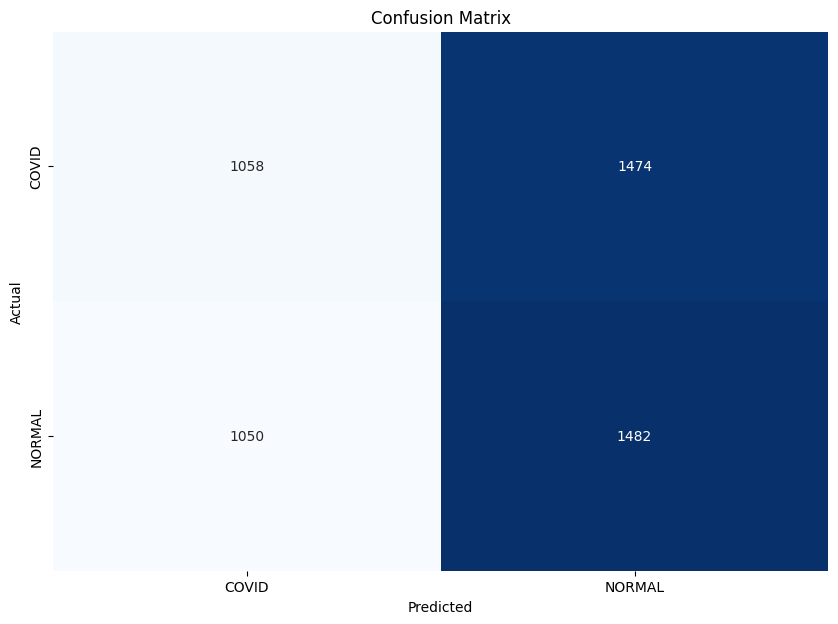

In [36]:
cf_matrix = confusion_matrix(y_true, y_pred)
class_names = list(validation_generator.class_indices.keys())
cf_matrix_df = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(cf_matrix_df)
plt.figure(figsize=(10, 7))
sns.heatmap(cf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [37]:
xception_model.save('Xception-Covid.hs')